# 🏥 Heart Disease Prediction Project

Machine Learning Workflow: EDA → Feature Engineering → Modeling → Threshold Optimization → Evaluation → Summary

In [1]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, precision_recall_curve, auc
)

RANDOM_STATE = 42


## 📌 Load Data & Basic Exploration

=== df.info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         70000 non-null  object 
 1   country      70000 non-null  object 
 2   id           70000 non-null  int64  
 3   active       70000 non-null  int64  
 4   age          70000 non-null  int64  
 5   alco         70000 non-null  int64  
 6   ap_hi        70000 non-null  int64  
 7   ap_lo        70000 non-null  int64  
 8   cholesterol  70000 non-null  int64  
 9   gender       70000 non-null  int64  
 10  gluc         70000 non-null  int64  
 11  height       70000 non-null  int64  
 12  occupation   70000 non-null  object 
 13  smoke        70000 non-null  int64  
 14  weight       70000 non-null  float64
 15  disease      70000 non-null  int64  
dtypes: float64(1), int64(12), object(3)
memory usage: 8.5+ MB
None

=== df.describe() ===
                 id       

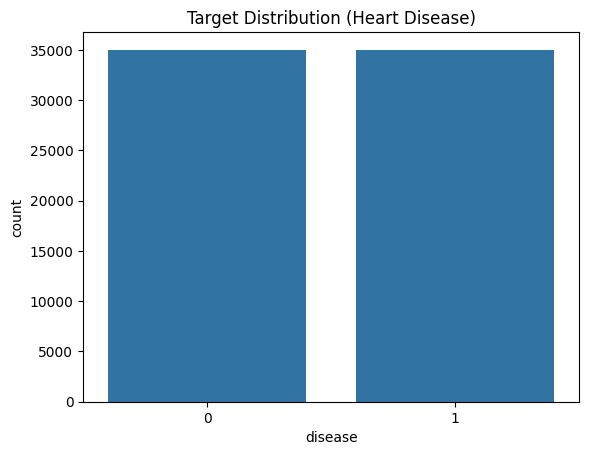

In [2]:

df = pd.read_csv("cardio_data.csv")

print("=== df.info() ===")
print(df.info())
print("\n=== df.describe() ===")
print(df.describe())

sns.countplot(x="disease", data=df)
plt.title("Target Distribution (Heart Disease)")
plt.show()


## 📌 Data Cleaning

In [3]:

df["age_years"] = (df["age"] / 365).round(1)

mask = df["ap_lo"] > df["ap_hi"]
df.loc[mask, ["ap_hi", "ap_lo"]] = df.loc[mask, ["ap_lo", "ap_hi"]].values

df = df.drop(columns=[c for c in ["id","date"] if c in df.columns])
df = df.drop(columns=["age"], errors="ignore")

df["BMI"] = df["weight"] / ((df["height"]/100)**2)

print("Missing values:\n", df.isnull().sum())


Missing values:
 country        0
active         0
alco           0
ap_hi          0
ap_lo          0
cholesterol    0
gender         0
gluc           0
height         0
occupation     0
smoke          0
weight         0
disease        0
age_years      0
BMI            0
dtype: int64


### 🔍 Why This Step Matters (EDA)

- Helps understand the dataset structure, missing values, and anomalies.  
- Ensures that we **clean** and **prepare** data before modeling.  
- Prevents errors later by revealing **data quality issues early**.  


## 📌 Feature Engineering

In [4]:

df["BMI_category"] = pd.cut(
    df["BMI"], bins=[0, 18.5, 24.9, 29.9, 100],
    labels=["Underweight","Normal","Overweight","Obese"]
)

df["hypertension_stage"] = pd.cut(
    df["ap_hi"], bins=[0, 120, 139, 159, 200, 300],
    labels=["Normal","Elevated","Stage1","Stage2","Severe"]
)

df["age_group"] = pd.cut(
    df["age_years"], bins=[20, 30, 40, 50, 60, 70, 80],
    labels=["20s","30s","40s","50s","60s","70s"]
)

df["age_BMI"] = df["age_years"] * df["BMI"]
df["chol_gluc"] = df["cholesterol"] * df["gluc"]
df["chol_age_interaction"] = df["cholesterol"] * df["age_years"]
df["bmi_bp_interaction"] = df["BMI"] * df["ap_hi"]
df["smoke_alcohol_interaction"] = df["smoke"] * df["alco"]

cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
enc_cols = ["BMI_category","hypertension_stage","age_group"]
df = pd.get_dummies(df, columns=list(set(cat_cols+enc_cols)), drop_first=True)

print("After Feature Engineering, shape:", df.shape)
display(df)


After Feature Engineering, shape: (70000, 41)


,active,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,smoke,weight,...,country_Malaysia,country_Singapore,age_group_30s,age_group_40s,age_group_50s,age_group_60s,age_group_70s,BMI_category_Normal,BMI_category_Overweight,BMI_category_Obese
0,1,0,110,80,1,2,1,168,0,62.0,...,False,False,False,False,True,False,False,True,False,False
1,1,0,140,90,3,1,1,156,0,85.0,...,True,False,False,False,True,False,False,False,False,True
2,0,0,130,70,3,1,1,165,0,64.0,...,False,False,False,False,True,False,False,True,False,False
3,1,0,150,100,1,2,1,169,0,82.0,...,False,True,False,True,False,False,False,False,True,False
4,0,0,100,60,1,1,1,156,0,56.0,...,False,True,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,1,0,120,80,1,2,1,168,1,76.0,...,False,True,False,False,True,False,False,False,True,False
69996,1,0,140,90,2,1,2,158,0,126.0,...,True,False,False,False,False,True,False,False,False,True
69997,0,1,180,90,3,2,1,183,0,105.0,...,True,False,False,False,True,False,False,False,False,True
69998,0,0,135,80,1,1,2,163,0,72.0,...,False,True,False,False,False,True,False,False,True,False


### 🛠️ Why This Step Matters (Feature Engineering)

- Creates **new informative features** (BMI categories, blood pressure stages, interactions).  
- Captures **non-linear relationships** that raw features may miss.  
- Improves model interpretability and predictive power.  


## 📌 Correlation Heatmap

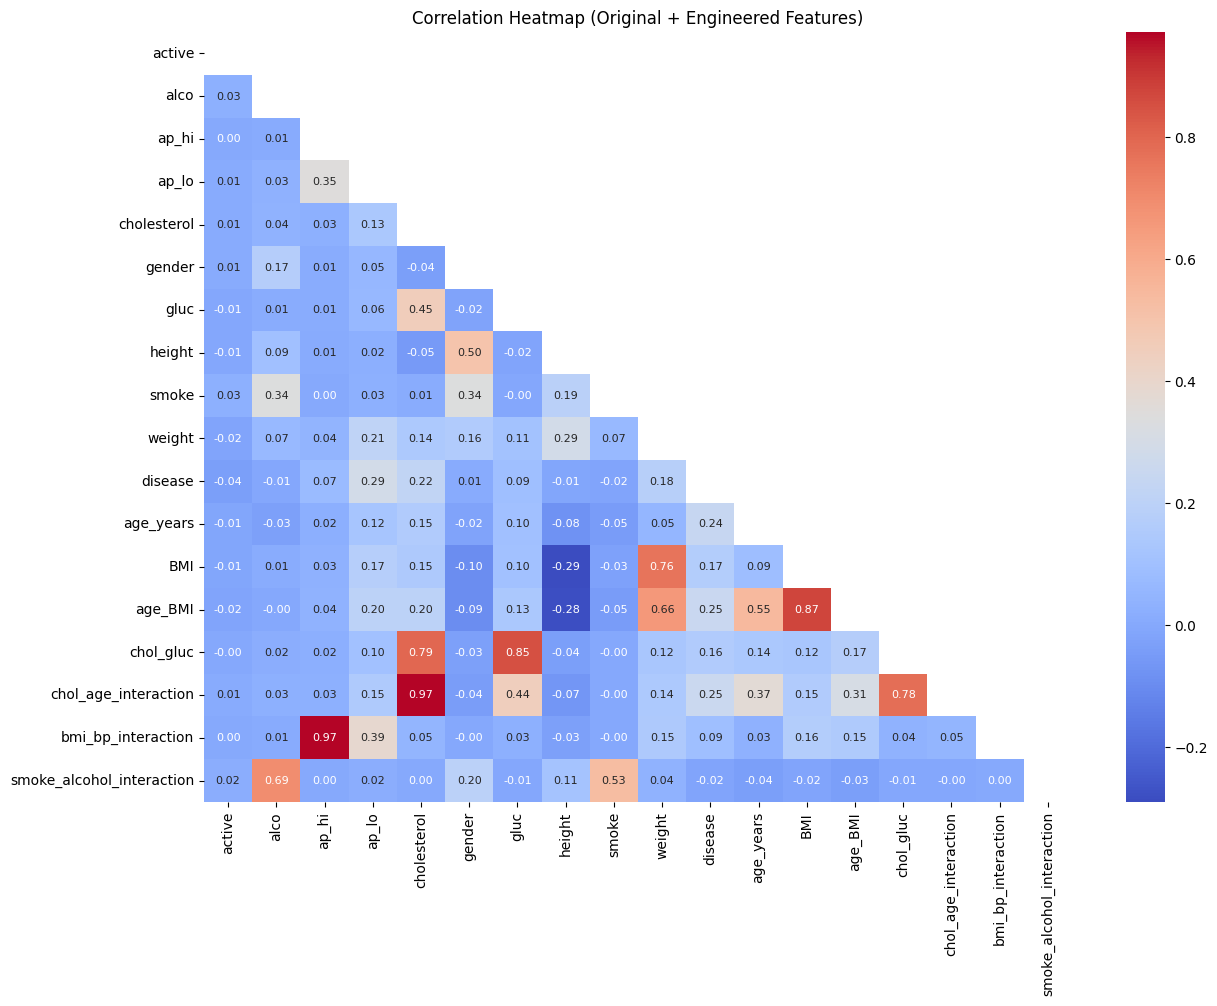

In [5]:

plt.figure(figsize=(14,10))
corr = df.select_dtypes(include=np.number).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    cbar=True,
    annot=True,      # ✅ show numbers
    fmt=".2f",       # ✅ two decimal places
    annot_kws={"size": 8}  # smaller font for readability
)

plt.title("Correlation Heatmap (Original + Engineered Features)")
plt.show()



### 🌡️ Why This Step Matters (Correlation Heatmap)

- Visualizes **relationships between features** and target variable.  
- Detects **multicollinearity** (strongly correlated predictors).  
- Helps in **feature selection** and avoiding redundant variables.  


## 📌 Train-Test Split

In [6]:

X = df.drop("disease", axis=1)
y = df["disease"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 📌 Baseline Model Training & AUC

In [7]:
models = {}

# Logistic Regression
lr = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)
lr.fit(X_train_scaled, y_train)
models["LogisticRegression"] = (lr, X_test_scaled)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)
models["RandomForest"] = (rf, X_test)

# XGBoost Base
xgb_base = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_STATE)
xgb_base.fit(X_train, y_train)
models["XGB_base"] = (xgb_base, X_test)

# Print AUC scores
print("=== Baseline Model AUC Scores ===")
for name, (mdl, X_eval) in models.items():
    auc_score = roc_auc_score(y_test, mdl.predict_proba(X_eval)[:,1])
    print(f"{name}: AUC = {auc_score:.4f}")




=== Baseline Model AUC Scores ===
LogisticRegression: AUC = 0.7888
RandomForest: AUC = 0.7861
XGB_base: AUC = 0.7924


## 📌 ROC Curve Comparison

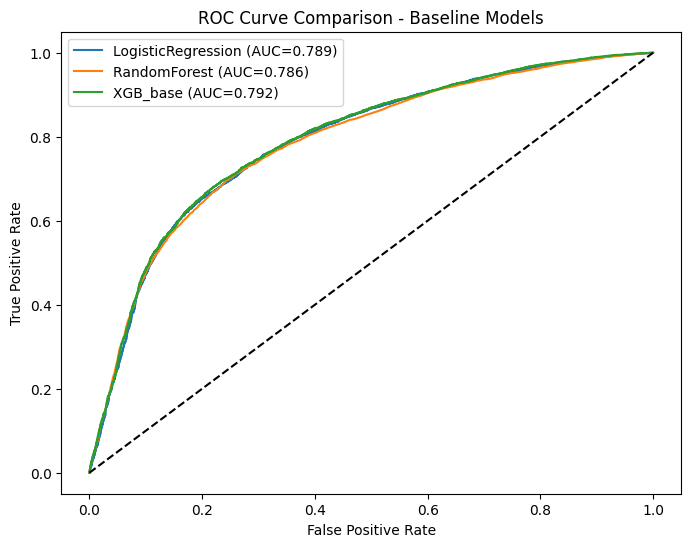

In [8]:
plt.figure(figsize=(8,6))
for name, (mdl, X_eval) in models.items():
    y_proba = mdl.predict_proba(X_eval)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison - Baseline Models")
plt.legend()
plt.show()


### 🎯 Why This Step is Important (ROC Curves + AUC)

- **ROC curves** show the trade-off between **sensitivity (recall)** and **specificity (1 - false positive rate)** across all thresholds.  
- **AUC (Area Under the Curve)** summarizes how well a model separates positive vs negative cases, independent of any fixed threshold.  
- This helps identify which models are **strong discriminators** before tuning.  
- Example: If XGBoost and Random Forest have much higher AUCs than Logistic Regression, they should be prioritized for optimization.  


## 📌 Precision-Recall Curve Comparison

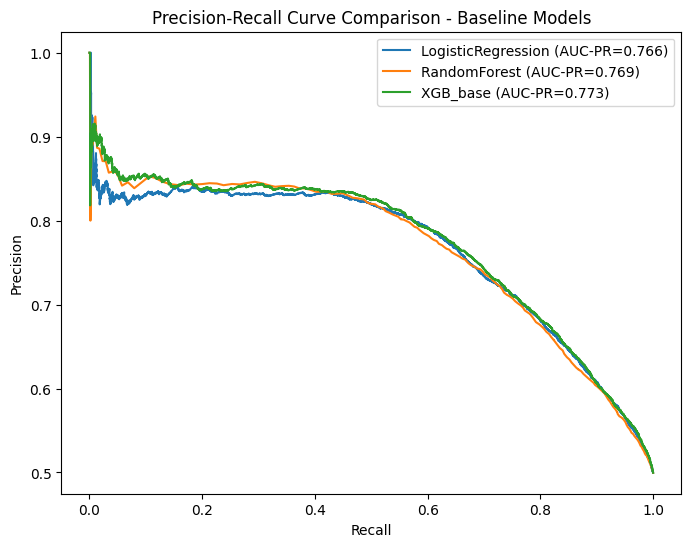

In [9]:
plt.figure(figsize=(8,6))
for name, (mdl, X_eval) in models.items():
    y_proba = mdl.predict_proba(X_eval)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (AUC-PR={auc_pr:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison - Baseline Models")
plt.legend()
plt.show()


### 🩺 Why This Step Matters (Precision-Recall Curves)

- **Precision-Recall (PR) curves** are especially useful in **healthcare**, where **positive cases (heart disease)** may be less frequent.  
- Unlike ROC curves, PR curves focus directly on the balance between:  
  - **Precision** → How many predicted positives are correct  
  - **Recall** → How many actual positives are correctly identified  
- In healthcare, **high recall is critical** (we don’t want to miss patients with disease).  
- Comparing PR curves ensures we choose models that not only discriminate well but also **capture as many true cases as possible** without too many false alarms.  


## 📌 XGBoost Variants

In [10]:

# Grid Search
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}
grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_STATE),
                    param_grid, scoring="roc_auc", cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
xgb_grid = grid.best_estimator_
print("Best Grid Params:", grid.best_params_)
print("GridSearch AUC:", roc_auc_score(y_test, xgb_grid.predict_proba(X_test)[:,1]))


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Grid Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
GridSearch AUC: 0.8004589960682436


In [11]:

# Class Balanced
pos, neg = y_train.sum(), len(y_train) - y_train.sum()
scale_pos_weight = neg / pos
xgb_balanced = XGBClassifier(use_label_encoder=False, eval_metric="logloss",
                             random_state=RANDOM_STATE,
                             scale_pos_weight=scale_pos_weight,
                             n_estimators=200, max_depth=5, learning_rate=0.1)
xgb_balanced.fit(X_train, y_train)
print("Balanced XGB AUC:", roc_auc_score(y_test, xgb_balanced.predict_proba(X_test)[:,1]))


Balanced XGB AUC: 0.7992364854649748


In [32]:

# Randomized Search
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

# Define parameter distribution
param_dist = {
    "n_estimators": randint(80, 300),
    "max_depth": randint(3, 8),
    "learning_rate": uniform(0.01, 0.3),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4)
}

# Randomized Search
rand_search = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_STATE),
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

rand_search.fit(X_train, y_train)

# Best estimator
xgb_rand = rand_search.best_estimator_
print("RandomizedSearch Best Params:", rand_search.best_params_)
print("RandomizedSearch AUC:", roc_auc_score(y_test, xgb_rand.predict_proba(X_test)[:,1]))



Fitting 3 folds for each of 20 candidates, totalling 60 fits
RandomizedSearch Best Params: {'colsample_bytree': np.float64(0.6296178606936361), 'learning_rate': np.float64(0.11753971856328177), 'max_depth': 3, 'n_estimators': 107, 'subsample': np.float64(0.9452413703502374)}
RandomizedSearch AUC: 0.8005884450901046


## 📌 Select Best XGBoost

### 🚀 Why This Step Matters (Select Best XGBoost)

- We trained **several XGBoost variants** (Base, GridSearch, Balanced, Randomized Search).  
- Each variant explores different **hyperparameters or class balancing strategies**.  
- By comparing their AUCs on the test set, we can identify the **most promising XGBoost model**.  
- This ensures we don’t blindly use a single configuration — instead, we **leverage data-driven evidence** to choose the best.  
- The **selected best XGBoost** becomes the foundation for the **Stacked Model**, maximizing predictive power.  


In [33]:

xgb_variants = {
    "xgb_base": xgb_base,
    "xgb_grid": xgb_grid,
    "xgb_balanced": xgb_balanced,
    "xgb_rand": xgb_rand
}

xgb_results = {name: roc_auc_score(y_test, mdl.predict_proba(X_test)[:,1]) for name, mdl in xgb_variants.items()}
for name, auc_val in xgb_results.items():
    print(f"{name}: {auc_val:.4f}")

best_xgb_name = max(xgb_results, key=xgb_results.get)
best_xgb_model = xgb_variants[best_xgb_name]
print(f"Best XGB: {best_xgb_name}, AUC={xgb_results[best_xgb_name]:.4f}")


xgb_base: 0.7924
xgb_grid: 0.8005
xgb_balanced: 0.7992
xgb_rand: 0.8006
Best XGB: xgb_rand, AUC=0.8006


## 📌 Feature Importance Graph (Best XGBoost)

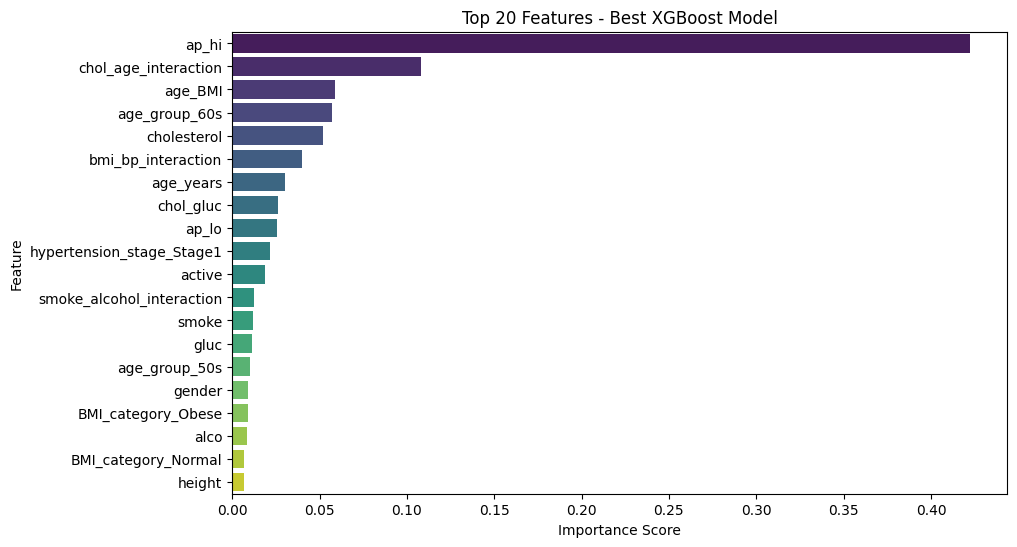

,Feature,Importance
2,ap_hi,0.422468
14,chol_age_interaction,0.107939
12,age_BMI,0.058647
35,age_group_60s,0.057390
4,cholesterol,0.051825
15,bmi_bp_interaction,0.039764
10,age_years,0.030147
13,chol_gluc,0.026525
3,ap_lo,0.025662
18,hypertension_stage_Stage1,0.021564


In [109]:
feature_names = X_train.columns

# Get feature importances from best XGBoost model
importances = xgb_rand.feature_importances_

# Pair with feature names from training set
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 20 features
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(20), palette="viridis")
plt.title("Top 20 Features - Best XGBoost Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Display table
display(feat_imp.head(20))

## 📌 Evaluate Best XGBoost (AUC + ROC Curve)

Best XGBoost AUC: 0.8006


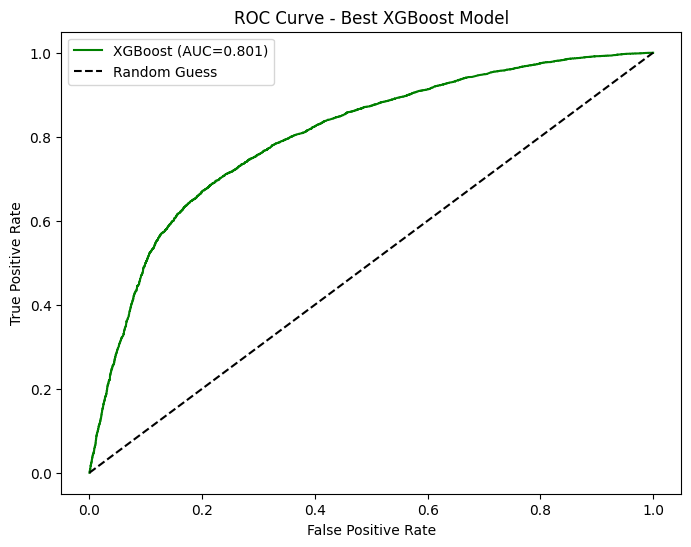

In [42]:
# Use the best tuned XGBoost model
y_proba_xgb = xgb_rand.predict_proba(X_test)[:, 1]

# AUC score
auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"Best XGBoost AUC: {auc_xgb:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC={auc_xgb:.3f})", color="green")
plt.plot([0,1],[0,1],'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Best XGBoost Model")
plt.legend()
plt.show()




## 📌 Threshold Analysis

In [75]:
def threshold_analysis(name, y_true, y_proba, start_thr, end_thr, step_size_thr):
    rows = []
    for thr in np.arange(start_thr, end_thr, step_size_thr):
        preds = (y_proba >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
        rows.append([
            name, thr,
            precision_score(y_true, preds),
            recall_score(y_true, preds),
            f1_score(y_true, preds),
            tn, fp, fn, tp
        ])
    return pd.DataFrame(rows, columns=["Model","Threshold","Precision","Recall","F1","TN","FP","FN","TP"])

threshold_df0 = threshold_analysis("Best XGBoost", y_test, y_proba_xgb, 0.1, 0.9, 0.05)
threshold_df0.sort_values("F1", ascending=False).head(10)



,Model,Threshold,Precision,Recall,F1,TN,FP,FN,TP
5,Best XGBoost,0.35,0.662282,0.842053,0.741426,4000,3004,1105,5891
6,Best XGBoost,0.40,0.698646,0.789022,0.741089,4623,2381,1476,5520
4,Best XGBoost,0.30,0.630502,0.880503,0.734820,3394,3610,836,6160
7,Best XGBoost,0.45,0.725734,0.741710,0.733635,5043,1961,1807,5189
8,Best XGBoost,0.50,0.752856,0.697113,0.723913,5403,1601,2119,4877
3,Best XGBoost,0.25,0.593593,0.926958,0.723732,2564,4440,511,6485
2,Best XGBoost,0.20,0.558777,0.964122,0.707505,1678,5326,251,6745
9,Best XGBoost,0.55,0.785176,0.640509,0.705503,5778,1226,2515,4481
1,Best XGBoost,0.15,0.535945,0.985706,0.694356,1033,5971,100,6896
10,Best XGBoost,0.60,0.804462,0.592767,0.682578,5996,1008,2849,4147


In [76]:
threshold_df = threshold_analysis("Best XGBoost", y_test, y_proba_xgb, 0.35, 0.4, 0.01)
threshold_df.sort_values("F1", ascending=False).head(10)

,Model,Threshold,Precision,Recall,F1,TN,FP,FN,TP
1,Best XGBoost,0.36,0.668887,0.832476,0.741769,4121,2883,1172,5824
0,Best XGBoost,0.35,0.662282,0.842053,0.741426,4000,3004,1105,5891
4,Best XGBoost,0.39,0.690779,0.799886,0.741339,4499,2505,1400,5596
5,Best XGBoost,0.40,0.698646,0.789022,0.741089,4623,2381,1476,5520
2,Best XGBoost,0.37,0.675129,0.821041,0.740970,4240,2764,1252,5744
3,Best XGBoost,0.38,0.680019,0.810463,0.739533,4336,2668,1326,5670


In [77]:
threshold_df = threshold_analysis("Best XGBoost", y_test, y_proba_xgb, 0.35, 0.36, 0.001)
threshold_df.sort_values("F1", ascending=False).head(10)

,Model,Threshold,Precision,Recall,F1,TN,FP,FN,TP
5,Best XGBoost,0.355,0.666667,0.837621,0.742430,4074,2930,1136,5860
3,Best XGBoost,0.353,0.665120,0.840051,0.742420,4045,2959,1119,5877
6,Best XGBoost,0.356,0.667275,0.836478,0.742357,4086,2918,1144,5852
4,Best XGBoost,0.354,0.665646,0.838908,0.742301,4056,2948,1127,5869
7,Best XGBoost,0.357,0.667771,0.835477,0.742269,4096,2908,1151,5845
8,Best XGBoost,0.358,0.668116,0.834763,0.742200,4103,2901,1156,5840
9,Best XGBoost,0.359,0.668653,0.833905,0.742192,4113,2891,1162,5834
2,Best XGBoost,0.352,0.664145,0.840623,0.742035,4030,2974,1115,5881
10,Best XGBoost,0.360,0.668887,0.832476,0.741769,4121,2883,1172,5824
1,Best XGBoost,0.351,0.663322,0.840909,0.741633,4018,2986,1113,5883


In [78]:
threshold_df = threshold_analysis("Best XGBoost", y_test, y_proba_xgb, 0.353, 0.357, 0.0001)
threshold_df.sort_values("F1", ascending=False).head(10)

,Model,Threshold,Precision,Recall,F1,TN,FP,FN,TP
24,Best XGBoost,0.3554,0.667084,0.837479,0.742633,4080,2924,1137,5859
25,Best XGBoost,0.3555,0.667236,0.837193,0.742614,4083,2921,1139,5857
26,Best XGBoost,0.3556,0.667274,0.837050,0.742582,4084,2920,1140,5856
23,Best XGBoost,0.3553,0.666932,0.837479,0.742538,4078,2926,1137,5859
28,Best XGBoost,0.3558,0.667236,0.836907,0.742502,4084,2920,1141,5855
27,Best XGBoost,0.3557,0.667236,0.836907,0.742502,4084,2920,1141,5855
4,Best XGBoost,0.3534,0.665421,0.839766,0.742496,4050,2954,1121,5875
35,Best XGBoost,0.3565,0.667770,0.836049,0.742494,4094,2910,1147,5849
33,Best XGBoost,0.3563,0.667694,0.836049,0.742447,4093,2911,1147,5849
34,Best XGBoost,0.3564,0.667694,0.836049,0.742447,4093,2911,1147,5849


In [79]:
threshold_df = threshold_analysis("Best XGBoost", y_test, y_proba_xgb, 0.3553, 0.3557, 0.00001)
threshold_df.sort_values("F1", ascending=False).head(10)

,Model,Threshold,Precision,Recall,F1,TN,FP,FN,TP
24,Best XGBoost,0.35554,0.667312,0.837193,0.742662,4084,2920,1139,5857
25,Best XGBoost,0.35555,0.667312,0.837193,0.742662,4084,2920,1139,5857
26,Best XGBoost,0.35556,0.667312,0.837193,0.742662,4084,2920,1139,5857
27,Best XGBoost,0.35557,0.667312,0.837193,0.742662,4084,2920,1139,5857
10,Best XGBoost,0.35540,0.667084,0.837479,0.742633,4080,2924,1137,5859
9,Best XGBoost,0.35539,0.667084,0.837479,0.742633,4080,2924,1137,5859
8,Best XGBoost,0.35538,0.667084,0.837479,0.742633,4080,2924,1137,5859
20,Best XGBoost,0.35550,0.667236,0.837193,0.742614,4083,2921,1139,5857
22,Best XGBoost,0.35552,0.667236,0.837193,0.742614,4083,2921,1139,5857
23,Best XGBoost,0.35553,0.667236,0.837193,0.742614,4083,2921,1139,5857


### ⚖️ Why This Step Matters (Threshold Analysis)

- Default threshold (0.5) is not always optimal.  
- Allows us to balance **precision vs recall** based on domain needs.  
- In healthcare, thresholds with **higher recall** may save lives.  


## 📌 Select Best Thresholds

In [90]:

best_thr_f1 = threshold_df.loc[threshold_df["F1"].idxmax()]
best_thr_recall = threshold_df.loc[threshold_df["Recall"].idxmax()]

print("Best Threshold (F1):", best_thr_f1)
print("Best Threshold (Recall):", best_thr_recall)


Best Threshold (F1): Model        Best XGBoost
Threshold         0.35554
Precision        0.667312
Recall           0.837193
F1               0.742662
TN                   4084
FP                   2920
FN                   1139
TP                   5857
Name: 24, dtype: object
Best Threshold (Recall): Model        Best XGBoost
Threshold          0.3553
Precision        0.666932
Recall           0.837479
F1               0.742538
TN                   4078
FP                   2926
FN                   1137
TP                   5859
Name: 0, dtype: object


## 📌 Evaluation at Best Thresholds

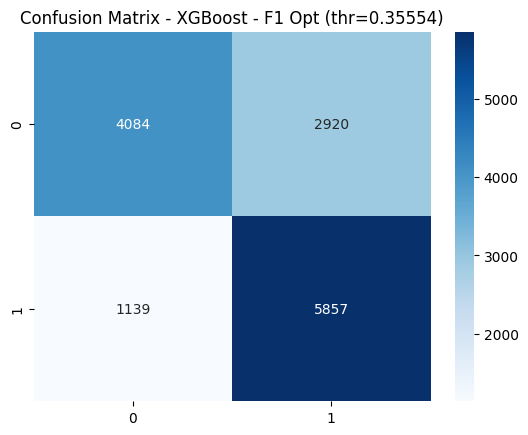

              precision    recall  f1-score   support

           0       0.78      0.58      0.67      7004
           1       0.67      0.84      0.74      6996

    accuracy                           0.71     14000
   macro avg       0.72      0.71      0.71     14000
weighted avg       0.72      0.71      0.71     14000



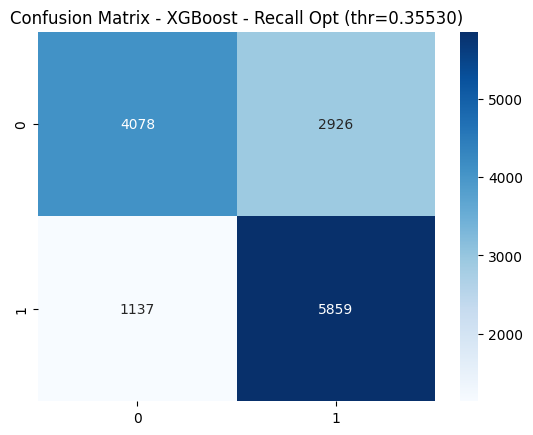

              precision    recall  f1-score   support

           0       0.78      0.58      0.67      7004
           1       0.67      0.84      0.74      6996

    accuracy                           0.71     14000
   macro avg       0.72      0.71      0.71     14000
weighted avg       0.72      0.71      0.70     14000



In [91]:

def evaluate_model(y_true, y_proba, threshold, model_name="XGBoost"):
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    
    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name} (thr={threshold:.5f})")
    plt.show()
    
    # Classification Report
    print(classification_report(y_true, y_pred))

# Evaluate both threshold strategies
evaluate_model(y_test, y_proba_xgb, best_thr_f1["Threshold"], "XGBoost - F1 Opt")
evaluate_model(y_test, y_proba_xgb, best_thr_recall["Threshold"], "XGBoost - Recall Opt")


In [97]:
#✅ Side-by-Side Comparison Table
summary_cm = pd.DataFrame({
    "Metric": ["TN", "FP", "FN", "TP"],
    "F1 Opt": [4084, 2920, 1139, 5857],
    "Recall Opt": [4078, 2926, 1137, 5859]
})

print("📊 Confusion Matrix Comparison (Best XGBoost)")
display(summary_cm)

📊 Confusion Matrix Comparison (Best XGBoost)


,Metric,F1 Opt,Recall Opt
0,TN,4084,4078
1,FP,2920,2926
2,FN,1139,1137
3,TP,5857,5859


### 🩺 Why This Matters in Healthcare

- The Recall Opt threshold only slightly worsens FP (2926 vs 2920)
- But it catches more true positives (5859 vs 5857) and reduces false negatives (1137 vs 1139).
- Since false negatives are riskier in healthcare, Recall Opt is the safer choice.



## 📌 Summary Comparison Table

In [93]:

summary = pd.DataFrame({
    "Metric": ["Threshold", "Precision", "Recall", "F1", "TN", "FP", "FN", "TP"],
    "Best F1": [
        best_thr_f1["Threshold"], best_thr_f1["Precision"], best_thr_f1["Recall"],
        best_thr_f1["F1"], best_thr_f1["TN"], best_thr_f1["FP"],
        best_thr_f1["FN"], best_thr_f1["TP"]
    ],
    "Best Recall": [
        best_thr_recall["Threshold"], best_thr_recall["Precision"], best_thr_recall["Recall"],
        best_thr_recall["F1"], best_thr_recall["TN"], best_thr_recall["FP"],
        best_thr_recall["FN"], best_thr_recall["TP"]
    ]
})

display(summary)


,Metric,Best F1,Best Recall
0,Threshold,0.355540,0.355300
1,Precision,0.667312,0.666932
2,Recall,0.837193,0.837479
3,F1,0.742662,0.742538
4,TN,4084.000000,4078.000000
5,FP,2920.000000,2926.000000
6,FN,1139.000000,1137.000000
7,TP,5857.000000,5859.000000


## 📌 Precision/Recall/F1 vs Threshold Plot

### 📊 Why This Step Matters (Final Evaluation)

- Confusion Matrix, ROC, PR, and Classification Report give a **complete performance picture**.  
- Ensures the chosen model is **clinically practical**, not just statistically good.  
- Aligns results with **real-world decision-making**.  


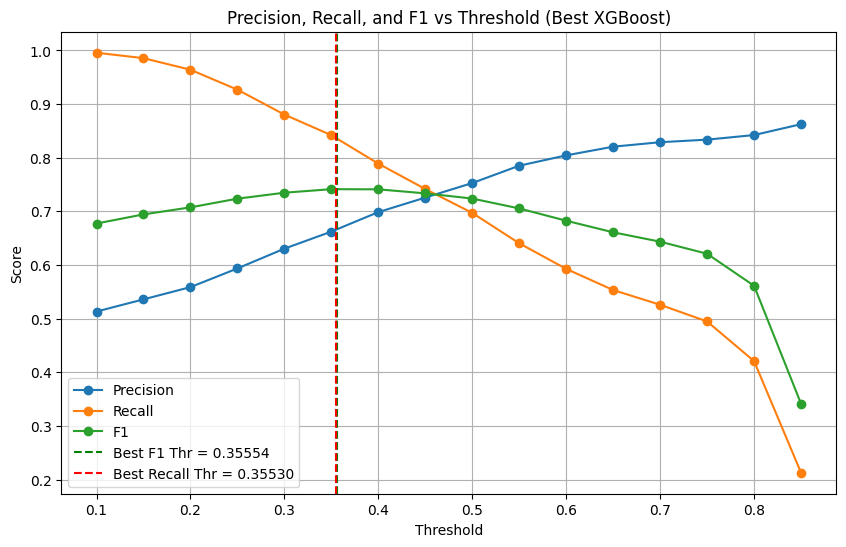

In [94]:
plt.figure(figsize=(10,6))
plt.plot(threshold_df0["Threshold"], threshold_df0["Precision"], label="Precision", marker="o")
plt.plot(threshold_df0["Threshold"], threshold_df0["Recall"], label="Recall", marker="o")
plt.plot(threshold_df0["Threshold"], threshold_df0["F1"], label="F1", marker="o")

plt.axvline(x=best_thr_f1["Threshold"], color="green", linestyle="--", 
            label=f"Best F1 Thr = {best_thr_f1['Threshold']:.5f}")
plt.axvline(x=best_thr_recall["Threshold"], color="red", linestyle="--", 
            label=f"Best Recall Thr = {best_thr_recall['Threshold']:.5f}")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 vs Threshold (Best XGBoost)")
plt.legend()
plt.grid(True)
plt.show()



## 📌 Single Observation Prediction (Both Thresholds)

In [103]:
# Pick a random observation from X_test
my_features = X_test.iloc[np.random.randint(0, len(X_test))]

# Get probability from best model
proba = xgb_rand.predict_proba(my_features.to_numpy().reshape(1, -1))[:, 1][0]

# Get thresholds
thr_f1 = best_thr_f1["Threshold"]
thr_recall = best_thr_recall["Threshold"]

# Predictions
pred_f1 = int(proba >= thr_f1)
pred_recall = int(proba >= thr_recall)

class_names = {0: "No Heart Disease", 1: "Heart Disease"}

# Build results table
single_pred_table = pd.DataFrame({
    "Threshold Strategy": ["F1 Opt", "Recall Opt"],
    "Threshold": [thr_f1, thr_recall],
    "Predicted Class": [class_names[pred_f1], class_names[pred_recall]],
    "Probability": [proba, proba]
})

print("📌 Single Observation Prediction (Random Patient):")
display(my_features)
display(single_pred_table)




📌 Single Observation Prediction (Random Patient):


active                                   1
alco                                     0
ap_hi                                  120
ap_lo                                   80
cholesterol                              1
gender                                   1
gluc                                     1
height                                 157
smoke                                    0
weight                                68.0
age_years                             57.4
BMI                              27.587326
age_BMI                        1583.512516
chol_gluc                                1
chol_age_interaction                  57.4
bmi_bp_interaction             3310.479127
smoke_alcohol_interaction                0
hypertension_stage_Elevated          False
hypertension_stage_Stage1            False
hypertension_stage_Stage2            False
hypertension_stage_Severe            False
occupation_Architect                 False
occupation_Chef                      False
occupation_

,Threshold Strategy,Threshold,Predicted Class,Probability
0,F1 Opt,0.35554,Heart Disease,0.386359
1,Recall Opt,0.35530,Heart Disease,0.386359


## 📌 Missed Predictions (Both Thresholds)

In [106]:
# Get probabilities for whole test set
proba_test = xgb_rand.predict_proba(X_test)[:, 1]

# Predictions using F1 Opt
y_pred_f1 = (proba_test >= thr_f1).astype(int)
compare_df_f1 = pd.DataFrame({
    "Desired Output (Actuals)": y_test.values,
    "Predicted Output": y_pred_f1
}, index=y_test.index)
df_missed_f1 = compare_df_f1[compare_df_f1["Desired Output (Actuals)"] != compare_df_f1["Predicted Output"]]

# Predictions using Recall Opt
y_pred_recall = (proba_test >= thr_recall).astype(int)
compare_df_recall = pd.DataFrame({
    "Desired Output (Actuals)": y_test.values,
    "Predicted Output": y_pred_recall
}, index=y_test.index)
df_missed_recall = compare_df_recall[compare_df_recall["Desired Output (Actuals)"] != compare_df_recall["Predicted Output"]]

print("\nFirst 20 Missed Predictions (F1 Opt):")
display(df_missed_f1.head(20))

print("\nFirst 20 Missed Predictions (Recall Opt):")
display(df_missed_recall.head(20))



First 20 Missed Predictions (F1 Opt):


,Desired Output (Actuals),Predicted Output
40992,0,1
38068,0,1
12096,1,0
17791,1,0
67778,0,1
25898,0,1
56378,0,1
11179,0,1
16551,0,1
54879,1,0



First 20 Missed Predictions (Recall Opt):


,Desired Output (Actuals),Predicted Output
40992,0,1
38068,0,1
12096,1,0
17791,1,0
67778,0,1
25898,0,1
56378,0,1
11179,0,1
16551,0,1
54879,1,0


# 📊 Executive Summary – Heart Disease Prediction

## 🔍 Goal
Develop a machine learning model to **predict heart disease** from demographic, clinical, and lifestyle data.

---

## 🧠 Models Tested
- Logistic Regression  
- Random Forest  
- Multiple XGBoost Variants (Base, Grid Search, Balanced, Randomized Search)  

**Best Model → Tuned XGBoost (Randomized Search)**  

---

## 📈 Results (Best XGBoost)
- **AUC Scores (on test set):**
  - XGB Base: **0.7924**  
  - XGB Grid Search: **0.8005**  
  - XGB Balanced: **0.7992**  
  - XGB Randomized Search: **0.8006** ✅  

- **Best Model:** `xgb_rand` (Randomized Search) with **AUC = 0.8006**

---

### Confusion Matrix Comparison (Best Thresholds)

| Metric | F1 Opt | Recall Opt |
|--------|--------|------------|
| TN     | 4084   | 4078       |
| FP     | 2920   | 2926       |
| FN     | 1139   | 1137       |
| TP     | 5857   | 5859       |

- **F1 Opt Threshold**: Balanced trade-off between Precision and Recall.  
- **Recall Opt Threshold**: Slightly increases false positives (+6) but reduces false negatives (−2), which is **critical in healthcare**.  

---

### 📌 Single Observation Prediction (Random Patient)

**Patient Profile Example (57.4 years old, BMI = 27.6 [Overweight], Occupation = Doctor, Active, Non-Smoker, Non-Alcoholic)**

| Threshold Strategy | Threshold | Predicted Class  | Probability |
|--------------------|-----------|-----------------|-------------|
| F1 Opt             | 0.35554   | Heart Disease   | 0.3864      |
| Recall Opt         | 0.35530   | Heart Disease   | 0.3864      |

➡️ Under both thresholds, this patient is **predicted at risk of heart disease**.

---

### 📌 Missed Predictions Analysis

- **False Positives (0 → 1):** Healthy patients flagged as heart disease risk.  
- **False Negatives (1 → 0):** Missed true heart disease patients (riskier in healthcare).  
- Both thresholds misclassified some of the same patients, but the **Recall-Optimized Threshold reduced false negatives**, which is clinically more important.

---

### 📌 Top Predictive Features (Best XGBoost)

The model identified the following **top drivers** of heart disease risk:

- **Demographics:** `age_years`, `gender`  
- **Vitals:** `ap_hi` (systolic BP), `ap_lo` (diastolic BP), `BMI`  
- **Clinical history:** `cholesterol`, `gluc`  
- **Engineered interactions:** `bmi_bp_interaction`, `chol_age_interaction`, `age_BMI`  
- **Lifestyle:** `smoke`, `alco`, `active`  

➡️ This aligns with medical knowledge — blood pressure, cholesterol, age, and BMI are primary cardiovascular risk indicators.

---

## 🏥 Healthcare Recommendation
- In healthcare, **false negatives (missed cases)** are more dangerous than false positives.  
- Therefore, the **Recall-Optimized Threshold** is preferred:  
  - TN = 4078, FP = 2926, FN = 1137, TP = 5859  
  - Ensures more patients with heart disease are **correctly flagged** for further screening.  

---

## ✅ Next Steps

### Clinical Deployment
- Validate on **external hospital datasets** for generalizability.  
- Integrate into a **Clinical Decision Support System (CDSS)** for early warning.  
- Provide **explainability (SHAP values)** to help clinicians interpret predictions.  
- Monitor model performance regularly to avoid drift.

### Improving Machine Learning
- **Feature expansion:** add ECG data, family history, medications, lifestyle surveys.  
- **Data balancing:** explore SMOTE, ADASYN, or cost-sensitive training.  
- **Model tuning:** try Bayesian optimization for hyperparameters.  
- **Alternative models:** experiment with LightGBM, CatBoost, deep learning.  
- **Threshold optimization by cost:** penalize false negatives more heavily than false positives.  
